In [11]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from S00_utils import plot_res, store_results



In [2]:
df = pd.read_excel("output/data_train_2.xlsx")
df = df.set_index("Unnamed: 0")
df.index.names = ["id"]
df.head()

,m1,m2,m3,s1__approximate_entropy__m_2__r_0.7,s1__autocorrelation__lag_9,s1__autocorrelation__lag_8,s1__autocorrelation__lag_7,s1__longest_strike_above_mean,s1__autocorrelation__lag_6,s1__autocorrelation__lag_5,...,"s1__agg_autocorrelation__f_agg_""mean""__maxlag_40",s1__ar_coefficient__coeff_10__k_10,"s1__fft_coefficient__attr_""abs""__coeff_4",s1__ar_coefficient__coeff_8__k_10,s1__approximate_entropy__m_2__r_0.5,"s1__fft_coefficient__attr_""abs""__coeff_3",s1__approximate_entropy__m_2__r_0.1,y1,y2,y3
id,,,,,,,,,,,,,,,,,,,,,
E001,187.616451,1415.961916,2.557955,0.185766,-0.212687,-0.016548,0.180225,16,0.369965,0.545277,...,0.111814,0.275924,9.657168,-0.129524,0.281910,7.000403,0.130575,68.601545,1.058818,88.361693
E002,101.574829,1155.296145,1.610162,0.201643,-0.337147,-0.130801,0.081408,15,0.289928,0.485372,...,0.073067,0.295375,4.576206,-0.127716,0.287208,3.997053,0.138715,53.906180,0.928938,120.448962
E003,105.981660,1354.421797,1.471213,0.280074,-0.724746,-0.519171,-0.277401,12,-0.016292,0.245955,...,-0.103510,0.311143,0.164255,-0.115387,0.295983,0.149326,0.160892,46.590224,1.356625,87.797819
E004,183.202078,1143.123554,2.027678,0.181729,-0.174395,0.019032,0.211732,16,0.396457,0.566256,...,0.116791,-0.191406,10.139354,0.064453,0.286139,8.100158,0.120629,68.758466,0.840078,118.543881
E005,190.252994,1018.419233,2.150465,0.247459,-0.562449,-0.349593,-0.116660,13,0.122974,0.355548,...,-0.045042,0.286307,12.336134,-0.121797,0.293460,10.561980,0.144695,61.326411,0.925232,70.486440


In [3]:
colsY = ["y1", "y2", "y3"]
colsX = [c for c in df.columns if c not in colsY]

X = df[colsX]
Y = df[colsY]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
print(X_train.shape)
print(Y_train.shape)


(70, 52)
(70, 3)


In [4]:
scX = MinMaxScaler()
X_train_std = scX.fit_transform(X_train)
X_test_std = scX.transform(X_test)

scY = MinMaxScaler()
Y_train_std = scY.fit_transform(Y_train)
Y_test_std = scY.transform(Y_test)

In [5]:
# Convert to 2D PyTorch tensors
X_train_std = torch.tensor(X_train_std, dtype=torch.float32)
Y_train_std = torch.tensor(Y_train_std, dtype=torch.float32)
X_test_std = torch.tensor(X_test_std, dtype=torch.float32)
Y_test_std = torch.tensor(Y_test_std, dtype=torch.float32)

In [6]:
# Define the model
model = nn.Sequential(
    nn.Linear(X.shape[1], 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, Y.shape[1]),
)

# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

MSE: 0.01
RMSE: 0.08


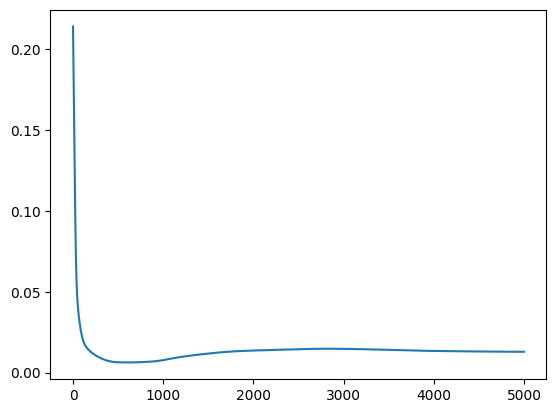

In [7]:
n_epochs = 5000  # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_mse = np.inf  # init to infinity
best_weights = None
history = []

for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train_std[start : start + batch_size]
            y_batch = Y_train_std[start : start + batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test_std)
    mse = loss_fn(y_pred, Y_test_std)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [9]:
Y_train_pred = model(X_train_std)
Y_test_pred = model(X_test_std)

In [ ]:
Y_train_std = Y_train_std.detach().numpy()
Y_test_std = Y_test_std.detach().numpy()
Y_train_pred = Y_train_pred.detach().numpy()
Y_test_pred = Y_test_pred.detach().numpy()

,MSE Train,MSE Test,R2 Train,R2 Test
0,0.006157,0.006883,0.890305,0.857427
1,0.001301,0.002276,0.977160,0.945980
2,0.003975,0.009734,0.925366,0.788047


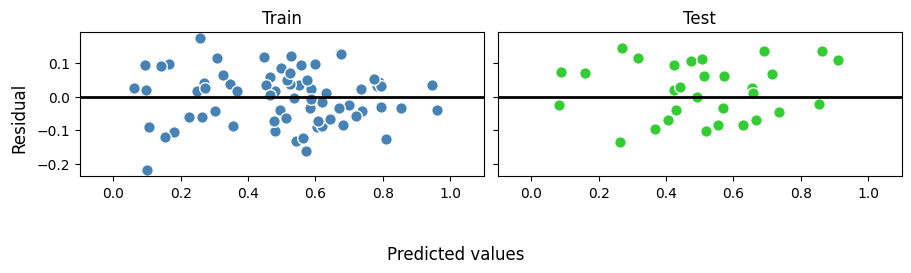

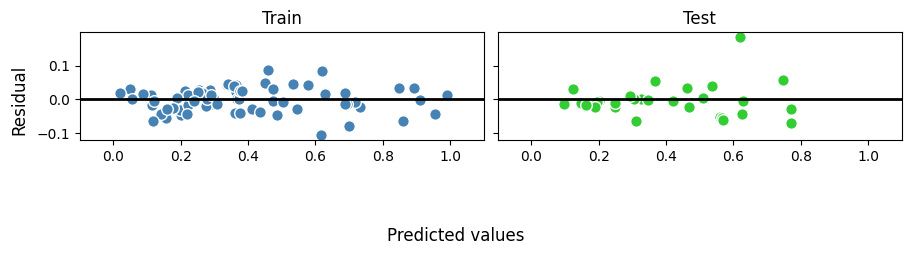

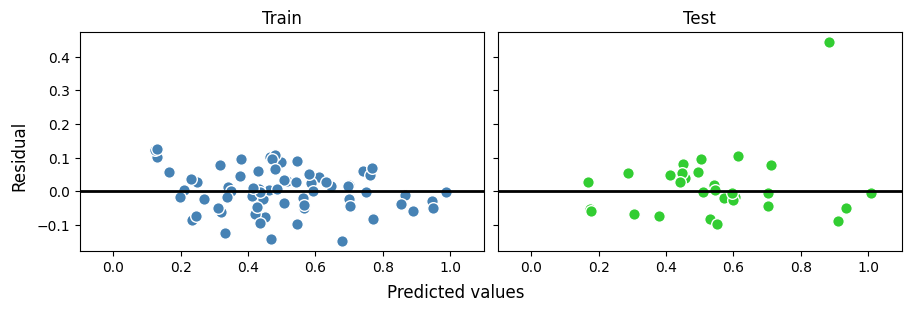

In [14]:
resArr = []
for i in range(Y.shape[1]):
    y_train = Y_train_std[:, i]
    y_test = Y_test_std[:, i]
    y_train_pred = Y_train_pred[:, i]
    y_test_pred = Y_test_pred[:, i]
    plot_res(y_train, y_test, y_train_pred, y_test_pred, xlim=[-0.1, 1.1])
    res = store_results(y_train, y_test, y_train_pred, y_test_pred)
    resArr.append(res)

dfRes = pd.DataFrame.from_dict(resArr)
dfRes